<a href="https://colab.research.google.com/github/CidClayQuirino/FuelBurnD155/blob/main/FuelBurnD155Komatsu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================
# 1. Instalar dependências
# ============================
!pip install geopandas matplotlib shapely fiona pyproj requests openpyxl

# ============================
# 2. Importar bibliotecas
# ============================
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import io

/tmp/ipython-input-431285654.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("RdYlGn_r")(norm)
/tmp/ipython-input-431285654.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c=plt.cm.get_cmap("RdYlGn_r")(
/tmp/ipython-input-431285654.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c=plt.cm.get_cmap("RdYlGn_r")(
/tmp/ipython-input-431285654.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotli

<Figure size 1200x1000 with 0 Axes>

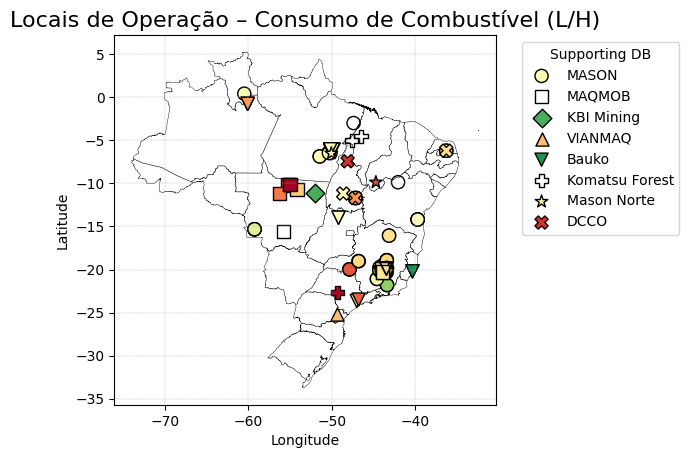

In [2]:
# ============================
# 3. Caminho para o arquivo no GitHub (RAW)
# ============================
github_raw_url = "https://raw.githubusercontent.com/CidClayQuirino/FuelBurnD155/b03494129c6ab92103ea053da623376ddafd1eeb/FuelBurn%20D155.xlsx"

# Baixar arquivo em memória
response = requests.get(github_raw_url)
file_bytes = io.BytesIO(response.content)

# Ler Excel
df = pd.read_excel(file_bytes)

# ============================
# 4. Tratar colunas numéricas com vírgula
# ============================
cols = ["LAT.", "LONG.", "Altitude[m]", "Fuel Consumption[L/H]"]

for c in cols:
    df[c] = df[c].astype(str).str.replace(",", ".", regex=False)
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Remover linhas sem coordenadas
df = df.dropna(subset=["LAT.", "LONG."])

# ============================
# 5. Carregar mapa do Brasil
# ============================
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
br_map = gpd.read_file(url)

# ============================
# 6. Criar GeoDataFrame dos pontos
# ============================
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["LONG."], df["LAT."]),
    crs="EPSG:4326"
)

# ============================
# 7. Criar mapa
# ============================
plt.figure(figsize=(12, 10))

# Desenhar mapa do Brasil
br_map.plot(edgecolor="black", facecolor="white", linewidth=0.3)

# Criar gradiente verde → vermelho baseado no consumo
fuel = gdf["Fuel Consumption[L/H]"]
norm = (fuel - fuel.min()) / (fuel.max() - fuel.min())

# Paleta: verde → amarelo → vermelho (invertida)
colors = plt.cm.get_cmap("RdYlGn_r")(norm)

# Ícones diferentes por Supporting DB
markers = ["o", "s", "D", "^", "v", "P", "*", "X"]
unique_dbs = gdf["Supporting DB"].unique()
marker_map = {db: markers[i % len(markers)] for i, db in enumerate(unique_dbs)}

# Plotar cada Supporting DB com ícone próprio
for db in unique_dbs:
    subset = gdf[gdf["Supporting DB"] == db]

    plt.scatter(
        subset["LONG."],
        subset["LAT."],
        s=90,
        c=plt.cm.get_cmap("RdYlGn_r")(
            (subset["Fuel Consumption[L/H]"] - fuel.min()) / (fuel.max() - fuel.min())
        ),
        marker=marker_map[db],
        label=db,
        edgecolor="black"
    )

plt.title("Locais de Operação – Consumo de Combustível (L/H)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True, linestyle="--", linewidth=0.3)
plt.legend(title="Supporting DB", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()



Observações lidas: 108


,Model,Serial No.,Supporting DB,LAT.,LONG.,Altitude[m],Fuel Consumption[L/H]
0,D155AX,80914,MASON,0.423666,-60.481300,83.0,26.2
1,D155AX,80915,MAQMOB,-15.555833,-55.812766,239.0,NaN
2,D155AX,81505,KBI Mining,-11.127433,-51.986166,253.0,10.4
3,D155AX,81674,MASON,-19.578633,-44.019899,752.0,30.4
4,D155AX,82086,VIANMAQ,-25.127166,-49.387133,942.0,35.9
5,D155AX,82133,Bauko,-20.212967,-40.324099,6.0,7.0
6,D155AX,82134,Bauko,-20.212866,-40.324867,6.0,6.5
7,D155AX,82184,MASON,-21.096266,-44.590633,867.0,27.4
8,D155AX,82185,Bauko,-0.744066,-60.092133,207.0,38.6
9,D155AX,82186,MASON,-9.863166,-42.055166,435.0,NaN


Método de imputação: median
Observações para análise: 108

Estatísticas descritivas (Fuel Consumption[L/H]):
count       : 108
mean        : 30.673148148148147
median      : 30.0
std         : 8.880721601579623
var         : 78.86721616476294
min         : 2.2
max         : 52.8
skew        : -0.13802250615875167
kurtosis    : 1.4646533426280874
mad_mean    : 6.035202331961591
mad_median  : 2.8499999999999996

Teste normalidade (p-value): 6.738375991740358e-05
Distribuição parece normal? Não (rejeita H0 de normalidade)

Outliers detectados:
IQR: 19  | z-score: 1  | mod-z: 11  | any: 19

Bootstrap 95% CI da média: [29.057, 32.341]

Resumo por Supporting DB:


,Supporting DB,count,mean,median,std,min,max
4,MAQMOB,10,39.920000,37.90,8.529400,30.0,52.8
6,Mason Norte,2,37.750000,37.75,12.091526,29.2,46.3
3,Komatsu Forest,3,37.333333,30.00,12.701706,30.0,52.0
1,DCCO,4,37.125000,36.30,8.387441,28.4,47.5
7,VIANMAQ,1,35.900000,35.90,NaN,35.9,35.9
0,Bauko,21,29.271429,28.40,9.117409,6.5,43.9
5,MASON,66,29.037879,30.00,7.370122,2.2,48.8
2,KBI Mining,1,10.400000,10.40,NaN,10.4,10.4



Resumo por Estado (onde disponível):


,state,count,mean,median,std
9,Piauí,1,46.300000,46.30,NaN
12,São Paulo,3,40.266667,43.90,13.910548
0,Amazonas,3,39.666667,38.90,1.594783
7,Paraná,1,35.900000,35.90,NaN
13,Tocantins,6,35.216667,33.70,7.770564
5,Mato Grosso,13,34.507692,30.00,12.248705
3,Goiás,2,32.300000,32.30,6.081118
10,Rio Grande do Norte,3,31.600000,32.20,1.493318
4,Maranhão,2,30.000000,30.00,0.000000
6,Minas Gerais,46,29.569565,30.00,7.942036



Correlação (Pearson) entre Fuel e Altitude/LAT/LONG:


,Fuel Consumption[L/H]
Altitude[m],-0.092912
LAT.,0.128056
LONG.,-0.241198


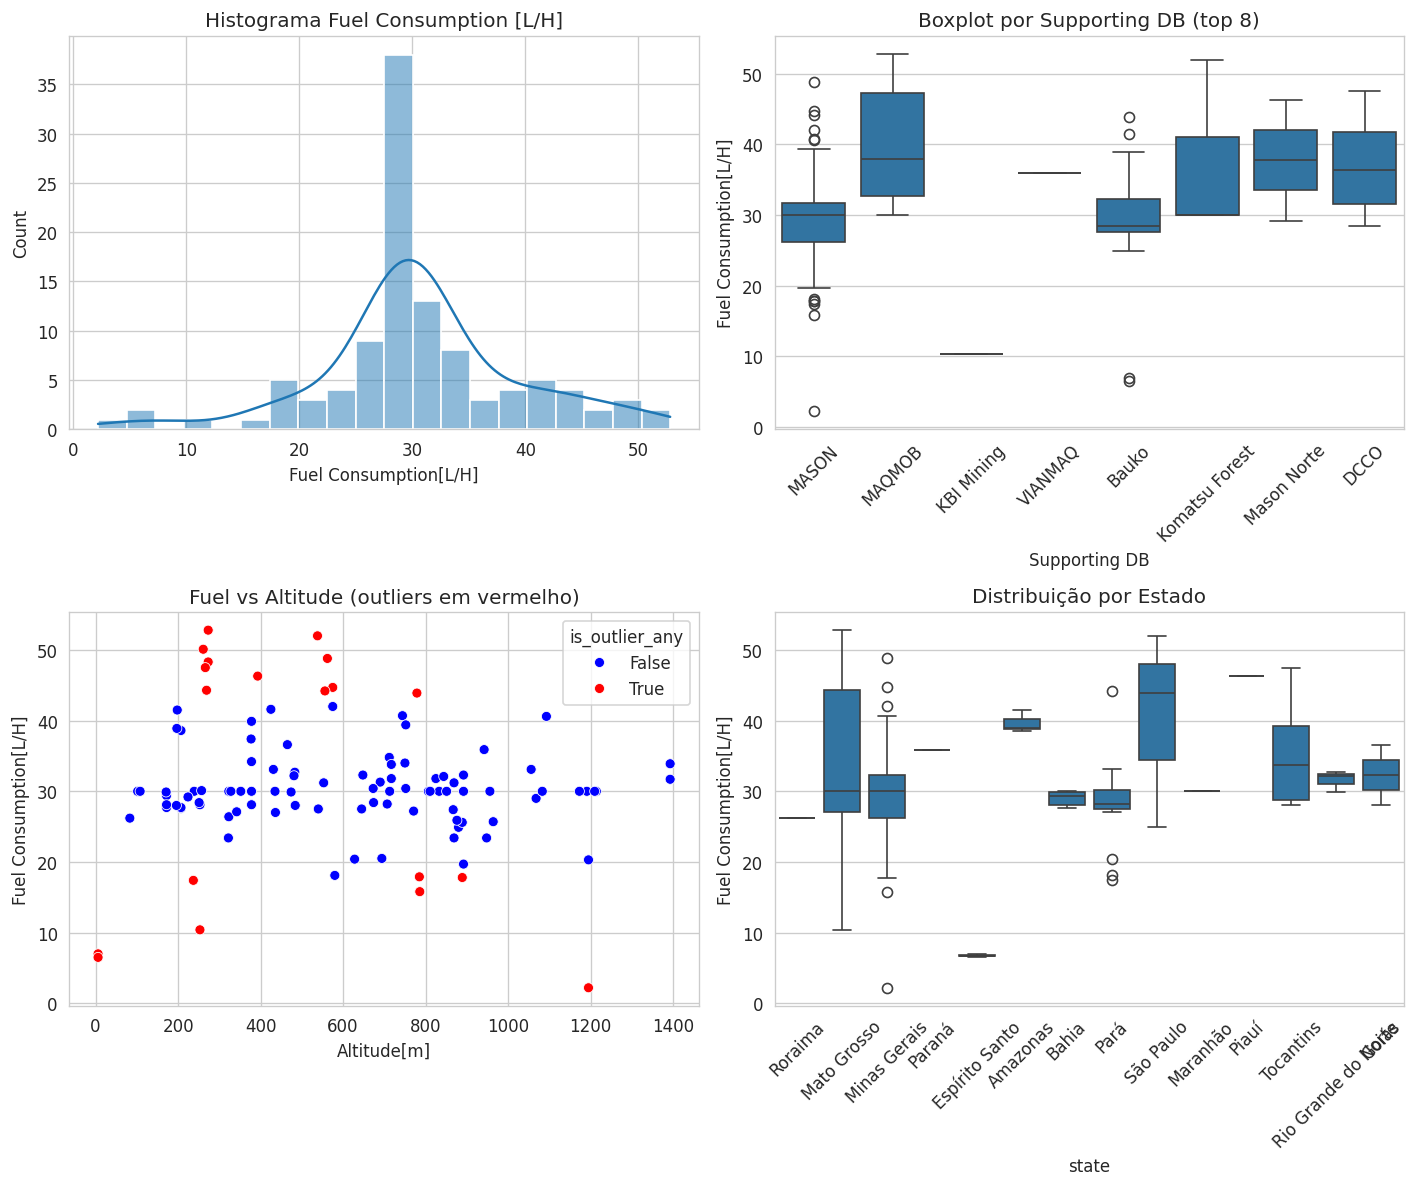


OLS regression summary:
                                OLS Regression Results                                
Dep. Variable:     Q("Fuel Consumption[L/H]")   R-squared:                       0.262
Model:                                    OLS   Adj. R-squared:                  0.186
Method:                         Least Squares   F-statistic:                     3.447
Date:                        Thu, 27 Nov 2025   Prob (F-statistic):           0.000666
Time:                                23:13:56   Log-Likelihood:                -372.18
No. Observations:                         108   AIC:                             766.4
Df Residuals:                              97   BIC:                             795.9
Df Model:                                  10                                         
Covariance Type:                    nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.97

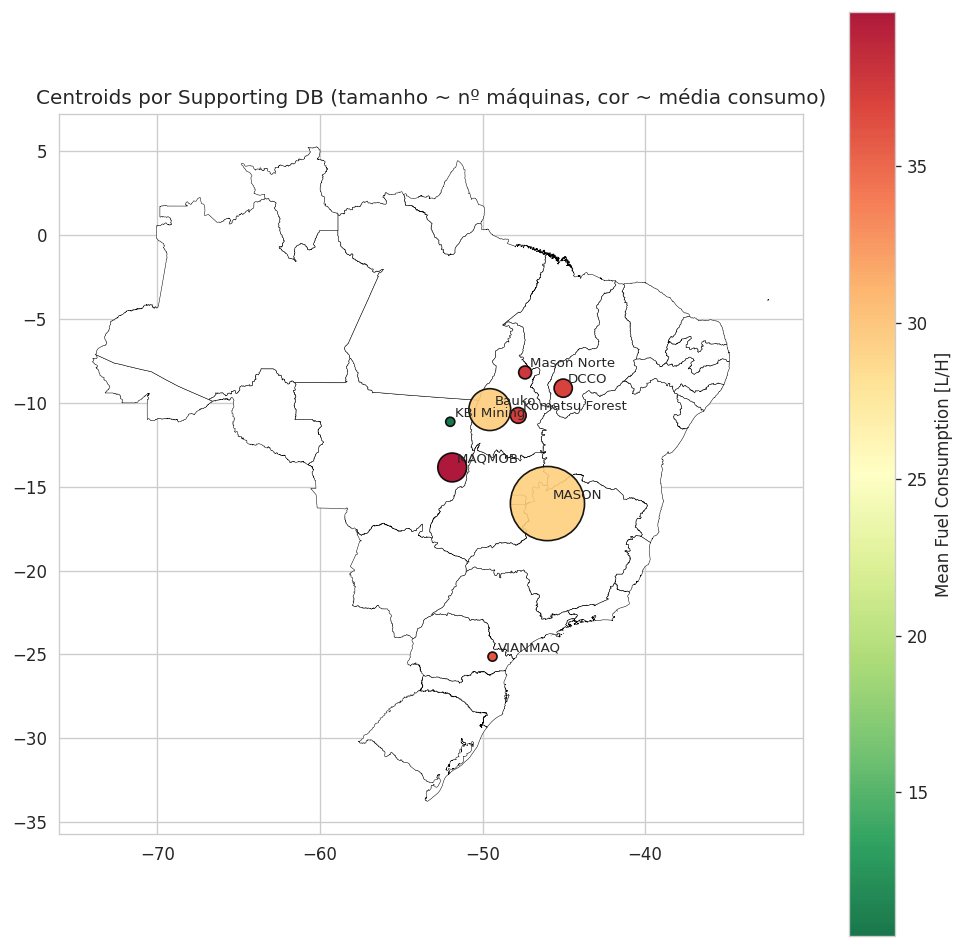


Arquivos salvos: resumo_supporting_db.csv, resumo_por_estado.csv (se disponível), dados_processados_com_outliers.csv


In [4]:
# ============================
# 0. Instalar dependências
# ============================
!pip install geopandas matplotlib seaborn pandas numpy scipy statsmodels scikit-learn openpyxl requests pyproj descartes

# ============================
# 1. Imports
# ============================
import io
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, RANSACRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 120

# ============================
# 2. Ler arquivo do GitHub (raw)
# ============================
github_raw_url = "https://raw.githubusercontent.com/CidClayQuirino/FuelBurnD155/b03494129c6ab92103ea053da623376ddafd1eeb/FuelBurn%20D155.xlsx"
resp = requests.get(github_raw_url)
resp.raise_for_status()
df = pd.read_excel(io.BytesIO(resp.content))

# ============================
# 3. Limpeza básica e tipos
# ============================
# Normalizar nomes de colunas removendo espaços extras
df.columns = [c.strip() for c in df.columns]

# Converter vírgulas decimais para ponto e forçar numéricos
num_cols = ["LAT.", "LONG.", "Altitude[m]", "Fuel Consumption[L/H]"]
for c in num_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).str.replace(",", ".").str.strip()
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Remover linhas sem coordenadas
df = df.dropna(subset=["LAT.", "LONG."]).reset_index(drop=True)

# Mostrar resumo inicial
print("Observações lidas:", len(df))
display(df.head(10))

# ============================
# 4. Tratamento de missing em Fuel Consumption (opções)
# ============================
# Estratégias possíveis: 'drop', 'median', 'mean', 'model'
IMPUTE_METHOD = "median"  # altere: "drop" | "median" | "mean" | "model"

if IMPUTE_METHOD == "drop":
    df_analysis = df.dropna(subset=["Fuel Consumption[L/H]"]).copy()
elif IMPUTE_METHOD in ("median", "mean"):
    fill = df["Fuel Consumption[L/H]"].median() if IMPUTE_METHOD == "median" else df["Fuel Consumption[L/H]"].mean()
    df_analysis = df.copy()
    df_analysis["Fuel Consumption[L/H]"] = df_analysis["Fuel Consumption[L/H]"].fillna(fill)
elif IMPUTE_METHOD == "model":
    # Simples imputação por regressão (Altitude, LAT, LONG)
    tmp = df.copy()
    features = ["Altitude[m]", "LAT.", "LONG."]
    train = tmp.dropna(subset=["Fuel Consumption[L/H]"] + features)
    predict = tmp[tmp["Fuel Consumption[L/H]"].isna() & tmp[features].notna().all(axis=1)]
    df_analysis = tmp.copy()
    if len(train) >= 10 and len(predict) > 0:
        X = train[features].values
        y = train["Fuel Consumption[L/H]"].values
        reg = LinearRegression().fit(X, y)
        df_analysis.loc[predict.index, "Fuel Consumption[L/H]"] = reg.predict(predict[features].values)
    else:
        # fallback para median
        df_analysis["Fuel Consumption[L/H]"] = df_analysis["Fuel Consumption[L/H]"].fillna(df["Fuel Consumption[L/H]"].median())
else:
    df_analysis = df.copy()

print("Método de imputação:", IMPUTE_METHOD)
print("Observações para análise:", df_analysis.shape[0])

# ============================
# 5. Estatísticas descritivas gerais
# ============================
fuel = df_analysis["Fuel Consumption[L/H]"].dropna()

# MAD clássico (média das distâncias absolutas à média)
mad_mean = (fuel - fuel.mean()).abs().mean()

# MAD robusto (distâncias absolutas à mediana)
mad_median = (fuel - fuel.median()).abs().median()

desc = {
    "count": fuel.count(),
    "mean": fuel.mean(),
    "median": fuel.median(),
    "std": fuel.std(),
    "var": fuel.var(),
    "min": fuel.min(),
    "max": fuel.max(),
    "skew": fuel.skew(),
    "kurtosis": fuel.kurtosis(),
    "mad_mean": mad_mean,      # substitui fuel.mad()
    "mad_median": mad_median   # versão robusta
}

print("\nEstatísticas descritivas (Fuel Consumption[L/H]):")
for k, v in desc.items():
    print(f"{k:12s}: {v}")

# ============================
# 6. Testes de normalidade e robustez
# ============================
# Shapiro-Wilk (cuidado com sample size > 5000)
shapiro_p = None
if len(fuel) <= 5000 and len(fuel) >= 3:
    shapiro_p = stats.shapiro(fuel)[1]
else:
    # usar D'Agostino K^2 para amostras maiores
    shapiro_p = stats.normaltest(fuel)[1]

print("\nTeste normalidade (p-value):", shapiro_p)
print("Distribuição parece normal?" , "Sim" if shapiro_p > 0.05 else "Não (rejeita H0 de normalidade)")

# ============================
# 7. Outliers detection (IQR, Z-score, Modified Z)
# ============================
def iqr_outliers(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k*iqr
    high = q3 + k*iqr
    return series[(series < low) | (series > high)].index

def zscore_outliers(series, thresh=3.0):
    z = np.abs(stats.zscore(series.fillna(series.mean())))
    return series.index[z > thresh]

def mod_zscore_outliers(series, thresh=3.5):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return pd.Index([])  # sem variação
    mod_z = 0.6745 * (series - median) / mad
    return series.index[np.abs(mod_z) > thresh]

iqr_idx = iqr_outliers(fuel)
z_idx = zscore_outliers(fuel)
modz_idx = mod_zscore_outliers(fuel)

outlier_flags = pd.Series(False, index=df_analysis.index)
outlier_flags.loc[iqr_idx] = True
outlier_flags.loc[z_idx] = True
outlier_flags.loc[modz_idx] = True

df_analysis["is_outlier_IQR"] = False
df_analysis.loc[iqr_idx, "is_outlier_IQR"] = True
df_analysis["is_outlier_z"] = False
df_analysis.loc[z_idx, "is_outlier_z"] = True
df_analysis["is_outlier_modz"] = False
df_analysis.loc[modz_idx, "is_outlier_modz"] = True
df_analysis["is_outlier_any"] = df_analysis[["is_outlier_IQR", "is_outlier_z", "is_outlier_modz"]].any(axis=1)

print("\nOutliers detectados:")
print("IQR:", len(iqr_idx), " | z-score:", len(z_idx), " | mod-z:", len(modz_idx), " | any:", df_analysis['is_outlier_any'].sum())

# ============================
# 8. Intervalo de confiança bootstrap para a média (95%)
# ============================
def bootstrap_ci_mean(data, n_boot=5000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    means = []
    arr = np.array(data.dropna())
    for _ in range(n_boot):
        sample = rng.choice(arr, size=len(arr), replace=True)
        means.append(sample.mean())
    lo = np.percentile(means, 100*(alpha/2))
    hi = np.percentile(means, 100*(1-alpha/2))
    return lo, hi

ci_lo, ci_hi = bootstrap_ci_mean(fuel)
print(f"\nBootstrap 95% CI da média: [{ci_lo:.3f}, {ci_hi:.3f}]")

# ============================
# 9. Agrupamentos: por Supporting DB e por Estado (spatial join)
# ============================
# Agrupar por Supporting DB
group_db = df_analysis.groupby("Supporting DB")["Fuel Consumption[L/H]"].agg(["count","mean","median","std","min","max"]).reset_index()
print("\nResumo por Supporting DB:")
display(group_db.sort_values("mean", ascending=False))

# Spatial join para obter Estado (usa geojson dos estados BR)
try:
    br_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
    br = gpd.read_file(br_url)[["name","geometry"]].rename(columns={"name":"state"})
    pts = gpd.GeoDataFrame(df_analysis.copy(), geometry=gpd.points_from_xy(df_analysis["LONG."], df_analysis["LAT."]), crs="EPSG:4326")
    pts = pts.to_crs(br.crs)
    br = br.to_crs(pts.crs)
    joined = gpd.sjoin(pts, br, how="left", predicate="within")
    df_analysis["state"] = joined["state"].values
    state_group = df_analysis.groupby("state")["Fuel Consumption[L/H]"].agg(["count","mean","median","std"]).reset_index()
    print("\nResumo por Estado (onde disponível):")
    display(state_group.sort_values("mean", ascending=False))
except Exception as e:
    print("Spatial join falhou:", e)
    df_analysis["state"] = np.nan

# ============================
# 10. Correlações e plots bivariados
# ============================
print("\nCorrelação (Pearson) entre Fuel e Altitude/LAT/LONG:")
corrs = df_analysis[["Fuel Consumption[L/H]","Altitude[m]","LAT.","LONG."]].corr()
display(corrs["Fuel Consumption[L/H]"].drop("Fuel Consumption[L/H]"))

# Gráficos
sns.set_style("whitegrid")
fig, axes = plt.subplots(2,2, figsize=(12,10))

# histograma + KDE
sns.histplot(df_analysis["Fuel Consumption[L/H]"].dropna(), kde=True, ax=axes[0,0])
axes[0,0].set_title("Histograma Fuel Consumption [L/H]")

# boxplot por Supporting DB (top 8 DBs)
top_dbs = df_analysis["Supporting DB"].value_counts().nlargest(8).index.tolist()
sns.boxplot(x="Supporting DB", y="Fuel Consumption[L/H]", data=df_analysis[df_analysis["Supporting DB"].isin(top_dbs)], ax=axes[0,1])
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_title("Boxplot por Supporting DB (top 8)")

# scatter vs Altitude
sns.scatterplot(x="Altitude[m]", y="Fuel Consumption[L/H]", data=df_analysis, ax=axes[1,0], hue="is_outlier_any", palette={False:"blue", True:"red"})
axes[1,0].set_title("Fuel vs Altitude (outliers em vermelho)")

# violino por estado (se houver)
if df_analysis["state"].notna().sum() > 0:
    sns.boxplot(x="state", y="Fuel Consumption[L/H]", data=df_analysis[df_analysis["state"].notna()], ax=axes[1,1])
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].set_title("Distribuição por Estado")
else:
    axes[1,1].axis("off")
plt.tight_layout()
plt.show()

# ============================
# 11. Regressão multivariada (Fuel ~ Altitude + LAT + LONG + C(Supporting DB))
# ============================
# Preparar data (dropar nans nas colunas usadas)
reg_df = df_analysis.dropna(subset=["Fuel Consumption[L/H]","Altitude[m]","LAT.","LONG."]).copy()
# formula com dummy para Supporting DB
formula = 'Q("Fuel Consumption[L/H]") ~ Q("Altitude[m]") + Q("LAT.") + Q("LONG.") + C(Q("Supporting DB"))'
model = ols(formula, data=reg_df).fit()
print("\nOLS regression summary:")
print(model.summary())

# Robust regression (RANSAC) como comparação
X = reg_df[["Altitude[m]","LAT.","LONG."]].values
# adicionar dummies para supporting db
db_dummies = pd.get_dummies(reg_df["Supporting DB"], drop_first=True)
X_full = np.hstack([X, db_dummies.values])
y = reg_df["Fuel Consumption[L/H]"].values
ransac = RANSACRegressor(random_state=42).fit(X_full, y)
y_pred = ransac.predict(X_full)
print("\nRANSAC R^2 score:", r2_score(y, y_pred))

# ============================
# 12. Gráfico mapa temático: média por Supporting DB (centroid)
# ============================
# calcular centroid por Supporting DB
centroids = df_analysis.groupby("Supporting DB").agg({
    "LAT.":"mean","LONG.":"mean","Fuel Consumption[L/H]":"mean","Serial No.":"count"
}).rename(columns={"Serial No.":"count","Fuel Consumption[L/H]":"mean_fuel"}).reset_index()

g_cent = gpd.GeoDataFrame(centroids, geometry=gpd.points_from_xy(centroids["LONG."], centroids["LAT."]), crs="EPSG:4326")

# plot mapa do Brasil e centroids com paleta contínua
try:
    base = br.to_crs("EPSG:4326")
    ax = base.plot(figsize=(10,10), color="white", edgecolor="black", linewidth=0.3)
    sc = ax.scatter(g_cent.geometry.x, g_cent.geometry.y, s=g_cent["count"]*30,
                    c=g_cent["mean_fuel"], cmap="RdYlGn_r", edgecolor="k", alpha=0.9)
    plt.colorbar(sc, label="Mean Fuel Consumption [L/H]")
    for idx, row in g_cent.iterrows():
        ax.annotate(row["Supporting DB"], xy=(row.geometry.x, row.geometry.y), xytext=(3,3), textcoords="offset points", fontsize=8)
    plt.title("Centroids por Supporting DB (tamanho ~ nº máquinas, cor ~ média consumo)")
    plt.show()
except Exception as e:
    print("Falha ao plotar mapa temático:", e)

# ============================
# 13. Exportar relatórios / resultados
# ============================
# salvar tabela de estatísticas por Supporting DB e por estado
group_db.to_csv("resumo_supporting_db.csv", index=False)
if 'state_group' in locals():
    state_group.to_csv("resumo_por_estado.csv", index=False)
df_analysis.to_csv("dados_processados_com_outliers.csv", index=False)

print("\nArquivos salvos: resumo_supporting_db.csv, resumo_por_estado.csv (se disponível), dados_processados_com_outliers.csv")
